In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import *
from datetime import datetime
from itertools import product
from sklearn.model_selection import train_test_split

In [2]:
# Read in data 
ev_raw = pd.read_csv("Electric_Vehicle_Population_Size_History_20241117.csv")

In [3]:
# Inspect data
ev_raw.head

<bound method NDFrame.head of                  Date  Plug-In Hybrid Electric Vehicle (PHEV) Count  \
0     January 31 2017                                          7688   
1    February 28 2017                                          7889   
2       March 31 2017                                          8093   
3       April 30 2017                                          8287   
4         May 31 2017                                          8497   
..                ...                                           ...   
88        May 31 2024                                         42037   
89       June 30 2024                                         42639   
90       July 31 2024                                         43531   
91     August 31 2024                                         44231   
92  September 30 2024                                         44611   

    Battery Electric Vehicle (BEV) Count  Electric Vehicle (EV) Total  
0                                  14741     

In [4]:
# Data types
print(ev_raw.dtypes)

Date                                            object
Plug-In Hybrid Electric Vehicle (PHEV) Count     int64
Battery Electric Vehicle (BEV) Count             int64
Electric Vehicle (EV) Total                      int64
dtype: object


In [5]:
# Rename
ev_clean = ev_raw.rename(columns = {'Date': 'date', 'Plug-In Hybrid Electric Vehicle (PHEV) Count': 'plugin_count', 'Battery Electric Vehicle (BEV) Count': 'bev_count', 'Electric Vehicle (EV) Total': 'ev_count'})

# Format Date
ev_clean['date'] = pd.to_datetime(ev_clean['date'])

# Set index and frequency 
ev_clean.set_index('date', inplace=True)
ev_clean = ev_clean.asfreq('M')

In [6]:
ev_clean.index.max()

Timestamp('2024-09-30 00:00:00', freq='M')

Text(0, 0.5, 'Number of EVs')

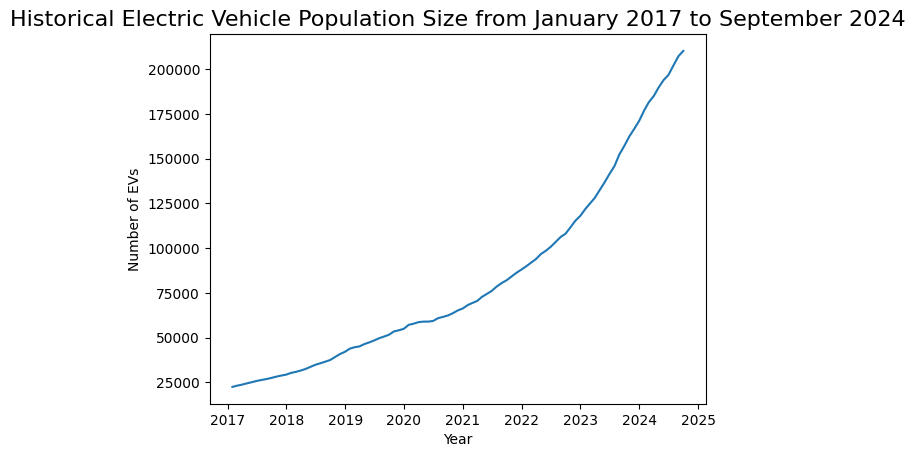

In [7]:
# plot

plt.plot(ev_clean.index, ev_clean['ev_count'])
plt.title("Historical Electric Vehicle Population Size from January 2017 to September 2024", fontsize=16, loc='center')
plt.xlabel("Year")
plt.ylabel("Number of EVs")

In [8]:
# Log - difference for percentage change 
ev_clean['ev_log'] = np.log(ev_clean['ev_count'])
ev_clean['ev_log_diff'] = ev_clean['ev_log'].diff().dropna()

Text(0, 0.5, 'Log-Diff')

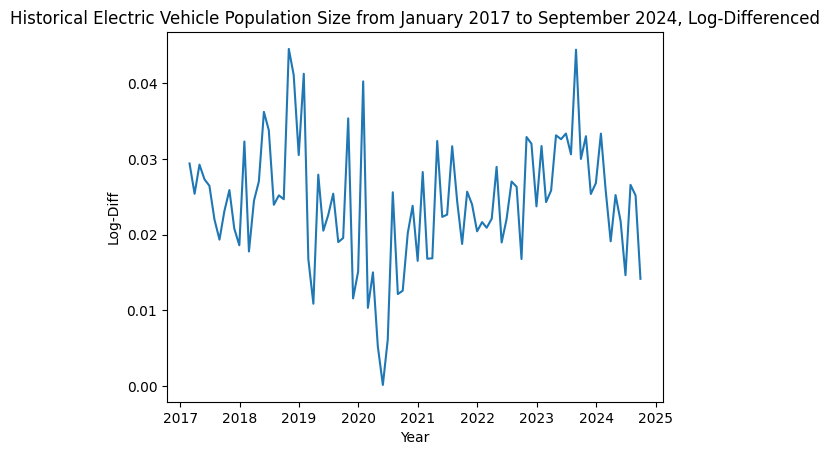

In [9]:
plt.plot(ev_clean.index, ev_clean['ev_log_diff'])
plt.title("Historical Electric Vehicle Population Size from January 2017 to September 2024, Log-Differenced")
plt.xlabel('Year')
plt.ylabel("Log-Diff")

In [10]:
# Dickey-Fuller test for stationarity
result=adfuller(ev_clean['ev_log_diff'].dropna())

print('ADF Statistic', result[0])
print('p-value', result[1])
print('Critical Values', result[4])

ADF Statistic -2.816328149227266
p-value 0.05597899517932277
Critical Values {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}


H0: The time series is non-stationary
HA: The times sereis is stationary
Our test statistic is greater than our critical value at 5% -2.816 > -2.894, the p-value is slightly creater than 0.05 at 0.056. We fail to reject he null hypothesis, however the time series is very close to stationary. At the 10% level it is considered stationary.


Text(0, 0.5, 'PACF')

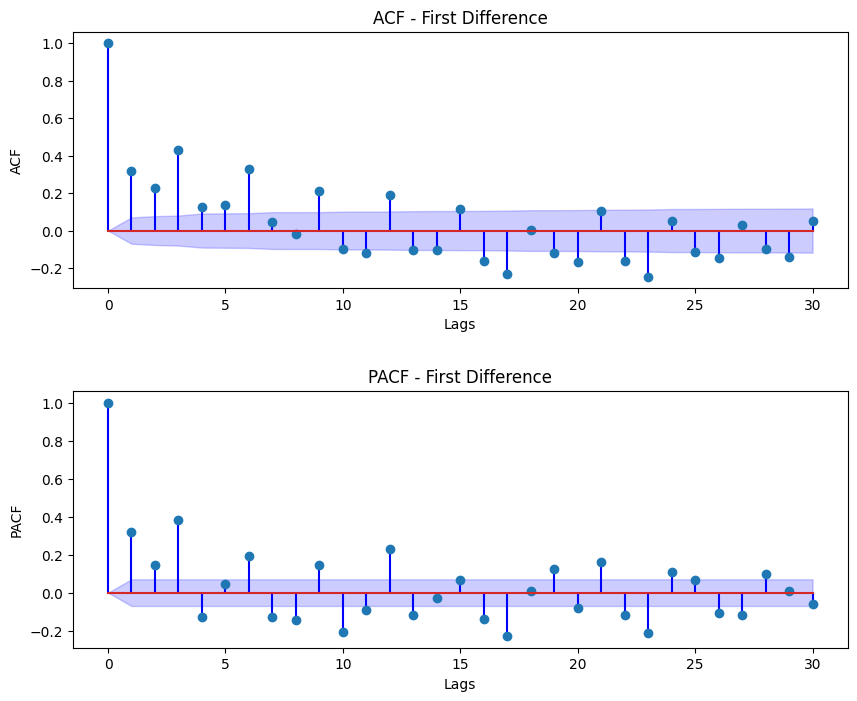

In [11]:
# Plot
registration_data = ev_clean['ev_log_diff'].dropna()

# ACF values and confidence intervals
acf_values, acf_confit = acf(registration_data, alpha=0.5, nlags=30)
pacf_values, pacf_confit = pacf(registration_data, alpha=0.5, nlags=30)

# Set figure size
fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={'hspace':0.4})

# ACF plot
ax[0].stem(range(len(acf_values)), acf_values, linefmt='b-')
ax[0].fill_between(range(len(acf_values)), acf_confit[:,0] - acf_values, acf_confit[:,1]-acf_values, color='blue', alpha=0.2)
ax[0].set_title('ACF - First Difference')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF')

# PACF plot
ax[1].stem(range(len(pacf_values)), pacf_values, linefmt='b-')
ax[1].fill_between(range(len(pacf_values)), pacf_confit[:,0]-pacf_values, pacf_confit[:,1]-pacf_values, color='blue', alpha=0.2)
ax[1].set_title('PACF - First Difference')
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('PACF')

In [12]:
# Take second difference
ev_clean['second_diff'] = ev_clean['ev_log_diff'].diff()

# Dickey-Fuller test for stationarity
result=adfuller(ev_clean['second_diff'].dropna())

print('ADF Statistic', result[0])
print('p-value', result[1])
print('Critical Values', result[4])

ADF Statistic -3.686360058186925
p-value 0.004309154516231539
Critical Values {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}


Text(0, 0.5, 'Log-Diff 2x')

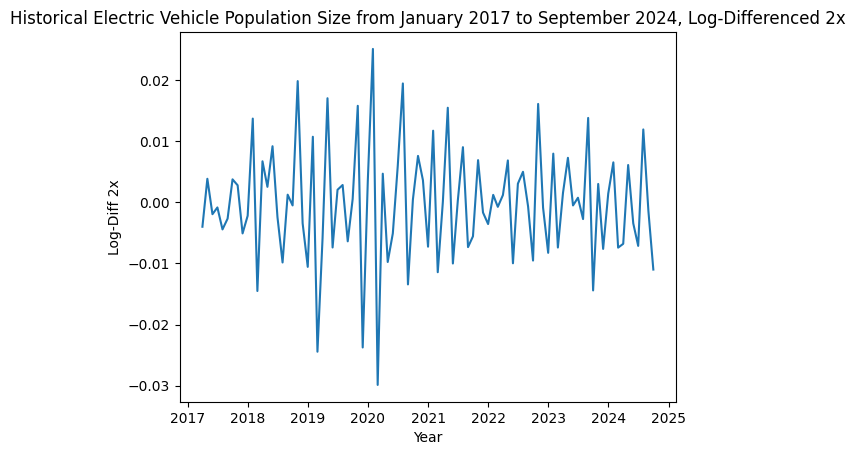

In [13]:
plt.plot(ev_clean.index, ev_clean['second_diff'])
plt.title("Historical Electric Vehicle Population Size from January 2017 to September 2024, Log-Differenced 2x")
plt.xlabel("Year")
plt.ylabel('Log-Diff 2x')

Now the time series is stationary, ADF statistic < critical value at 5% and a p-value of 0.004

Text(0, 0.5, 'PACF')

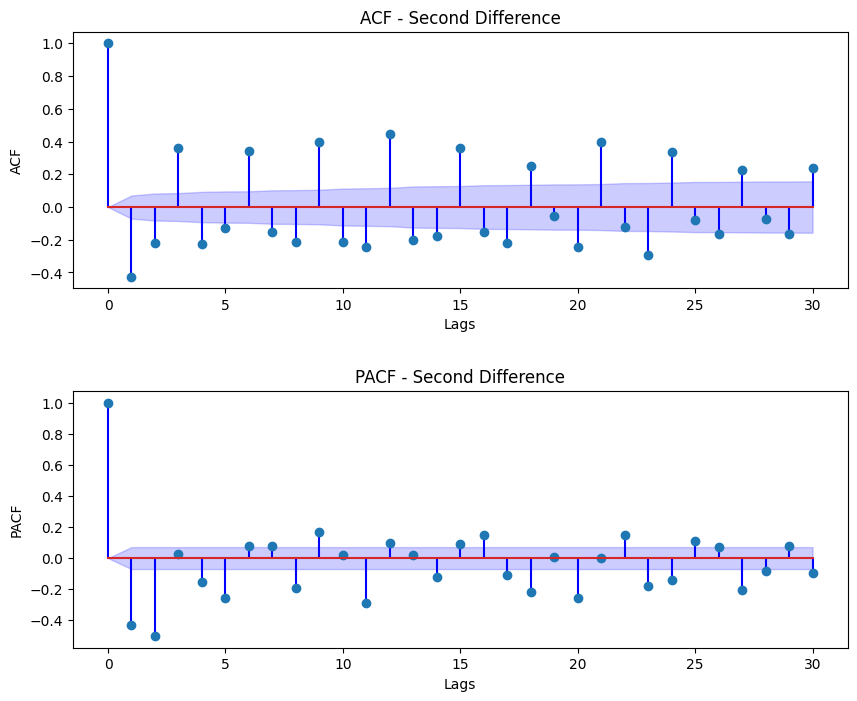

In [14]:
# Plot
registration_data2 = ev_clean['second_diff'].dropna()

# ACF values and confidence intervals
acf_values, acf_confit = acf(registration_data2, alpha=0.5, nlags=30)
pacf_values, pacf_confit = pacf(registration_data2, alpha=0.5, nlags=30)

# Set figure size
fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={'hspace':0.4})

# ACF plot
ax[0].stem(range(len(acf_values)), acf_values, linefmt='b-')
ax[0].fill_between(range(len(acf_values)), acf_confit[:,0] - acf_values, acf_confit[:,1]-acf_values, color='blue', alpha=0.2)
ax[0].set_title('ACF - Second Difference')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF')

# PACF plot
ax[1].stem(range(len(pacf_values)), pacf_values, linefmt='b-')
ax[1].fill_between(range(len(pacf_values)), pacf_confit[:,0]-pacf_values, pacf_confit[:,1]-pacf_values, color='blue', alpha=0.2)
ax[1].set_title('PACF - Second Difference')
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('PACF')

In [15]:
std_series_1 = registration_data.std()
std_series_2 = registration_data2.std()

print('Standard Deviation - First Difference:', std_series_1)
print('Standard Deviation - Second Difference:', std_series_2)

Standard Deviation - First Difference: 0.008192783781508098
Standard Deviation - Second Difference: 0.009559528347039685


In [21]:
# Test, train split
split_size = int(len(registration_data)*0.9)
train, test = registration_data[:split_size], registration_data[split_size:]

In [ ]:
# Iterate through different models to compare results

# Define parameter ranges
d = 0
D = 0
p_values = [0, 1, 2, 3] 
q_values = [0, 1, 2, 3]  
P_values = [0, 1, 2, 3]  
Q_values = [0, 1, 2, 3]  
s = 12 # Seasonality 

# Generate combinations
parameters = product(p_values, [d], q_values, P_values, [D], Q_values) 
best_aic = float("inf")
best_model = None

# Store results
results_list = []

for params in parameters:
    try: 
        model = sm.tsa.statespace.SARIMAX(
            train,
            order = params[:3],
            seasonal_order=params[3:] + (s,)
        )
        results = model.fit(disp=False)

        # Append
        results_list.append({
            'params' : params,
            'aic' : results.aic,
            'bic' : results.bic,
            'hqic': results.hqic,
            'model' : results
        })

    except Exception as e:
        print(f"Failed for parameters {params}: {e}")
        continue

results_df = pd.DataFrame(results_list)

results_df = results_df.sort_values(by='aic').reset_index(drop=True)
print(results_df)

In [22]:
results_df


,params,aic,bic,hqic,model
0,"(1, 0, 1, 1, 0, 0)",-559.542898,-549.916021,-555.677854,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,"(1, 0, 1, 1, 0, 1)",-559.373626,-547.340030,-554.542321,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,"(1, 0, 1, 2, 0, 0)",-559.006165,-546.972569,-554.174860,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,"(2, 0, 1, 1, 0, 1)",-558.035821,-543.595506,-552.238255,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,"(1, 0, 2, 1, 0, 0)",-557.802317,-545.768720,-552.971012,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
...,...,...,...,...,...
251,"(0, 0, 2, 0, 0, 0)",-454.120944,-446.900786,-451.222161,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
252,"(0, 0, 0, 0, 0, 2)",-450.681510,-443.461352,-447.782727,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
253,"(0, 0, 1, 0, 0, 0)",-434.490566,-429.677127,-432.558044,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
254,"(0, 0, 0, 0, 0, 1)",-413.386459,-408.573020,-411.453937,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [21]:
model = auto_arima(train, seasonal=True, stepwise=True, m=12, trace=False)
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                   82
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood                 288.592
Date:                                 Tue, 19 Nov 2024   AIC                           -565.184
Time:                                         16:31:16   BIC                           -550.744
Sample:                                     02-28-2017   HQIC                          -559.387
                                          - 11-30-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0076      0.003      2.223      0.026       0.001       0